## Code blocks here were tested initially here and were moved to reinforcement_learning.py

In [1]:
import torch
import random
import timeit
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import sys
# Add measurement mcts python package to path
sys.path.append('../src/measurement_mcts')
from measurement_mcts.environment.measurement_control_env import MeasurementControlEnvironment
from measurement_mcts.utils.utils import rotate_about_point, get_pixels_and_values
from measurement_mcts.state_evaluation.reinforcement_learning import MCTSRLWrapper

Toy Measurement Control Initialized


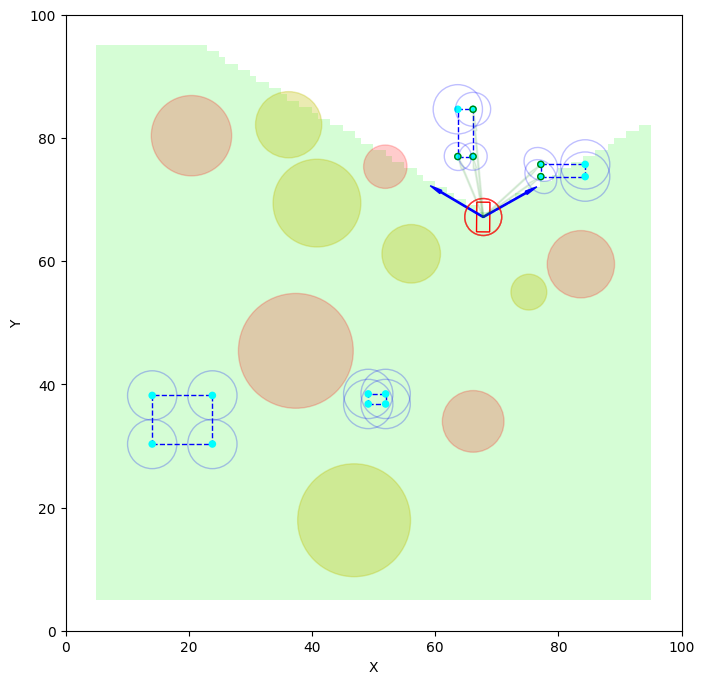

In [5]:
# Create the environment
env = MeasurementControlEnvironment()
env.draw_state(env.get_state())

In [16]:
# Create state image from car position, OOI corners, car width, car_length and obstacles
def get_image_based_state(env: MeasurementControlEnvironment, state: tuple, width_pixels=30, 
                          width_meters=50, explore_grid: np.ndarray=None, grid_origin: np.ndarray=None, meters_per_pixel: float=None) -> Tuple[np.ndarray, np.ndarray]:
    """Generate the image representation of the state the neural network will see

    Args:
        env (MeasurementControlEnvironment): The game environment
        state (tuple): Full state tuple
        width_pixels (int, optional): Width of image in pixels. Defaults to 30.
        width_meters (int, optional): Width of the image in meters. Defaults to 50.
        explore_grid (np.ndarray, optional): Exploration grid to overlay on image. Defaults to None.
        grid_origin (np.ndarray, optional): Origin of the grid in meters. Defaults to None.
        meters_per_pixel (float, optional): Meters per pixel for the explore grid. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray]: NN vector car state and NN image state
    """
    
    # Get obstacle means and radii
    # obstacle_means, obstacle_radii = env.eval_kd_tree.get_obstacle_points(), env.eval_kd_tree.get_obstacle_radii()

    # Pull out the state components
    car_state, object_df, explore_grid, horizon = state
    # corner_means = corner_means.reshape(-1, 2) # Reshape to 2D array where each row is a corner point
    
    # Get car collision length, width and car position and yaw
    car_width, car_length = env.car.width, env.car.length
    car_pos, car_yaw = car_state[:2], car_state[3]
    
    # Get normalized point covariances
    # pt_traces = env.get_normalized_cov_pt_traces(state)
    
    # Since image is body frame representation of car, obstacles and OOIs. The neural net only needs [vx, delta, delta_dot] as input
    # These are the components of the state which will determine how actions effect the car state, the rest of the state is used to generate the image
    non_image_car_state = car_state[[2, 4, 5]]
    
    # Make the image
    image = np.zeros((width_pixels, width_pixels), dtype=np.float32)
    
    # Calculate the scaling factor from meters to pixels
    scale = width_pixels / width_meters
    
    # If we have the parameters for the explore grid, overlay it on the image (done first to make sure it is in the background)
    if (explore_grid is not None) and (grid_origin is not None) and (meters_per_pixel is not None):        
        # Convert grid into W*Wx2 array where each row is a pixel and the columns are [x_idx, y_idx] combinations
        pixel_points, values = get_pixels_and_values(explore_grid)
        
        # Now convert the pixel points to world coords and then to car frame
        world_coords = grid_origin + meters_per_pixel * pixel_points
        car_trans_points = world_coords - car_state[:2] # rows are now [x_m, y_m] in car frame (but only translated)
        car_frame_points = rotate_about_point(car_trans_points, np.pi/2-car_yaw, np.array([0,0])) # rows are now [x_m, y_m] in car frame
        
        # Find which points are within the image bounds
        in_bounds = (-width_meters/2 <= car_frame_points[:, 0]) & (car_frame_points[:, 0] <= width_meters/2) & \
                    (-width_meters/2 <= car_frame_points[:, 1]) & (car_frame_points[:, 1] <= width_meters/2)
        
        # Place the in bounds points on the image
        in_bounds_pixels = (car_frame_points[in_bounds] * scale + width_pixels / 2).astype(int)
        image[in_bounds_pixels[:, 0], in_bounds_pixels[:, 1]] = values[in_bounds]
    
    # # Rotate the obstacle and corner points to the car's yaw angle
    # rotated_corners = rotate_about_point(corner_means, np.pi/2-car_yaw, car_pos) # Negative to rotate into a coordinate system where the car is facing up
    # rotated_obstacles = rotate_about_point(obstacle_means, np.pi/2-car_yaw, car_pos)
    
    # # Subtract the car's position from the rotated points to get the points relative to the car
    # rotated_corners -= car_state[:2]
    # rotated_obstacles -= car_state[:2]
    
    # # Find which points are within the image bounds
    # in_bounds_corners = (-width_meters/2 <= rotated_corners[:, 0]) & (rotated_corners[:, 0] <= width_meters/2) & \
    #                     (-width_meters/2 <= rotated_corners[:, 1]) & (rotated_corners[:, 1] <= width_meters/2)

    # # TODO: This does not account for the radius of the obstacles, it only goes onto the image if the center is in bounds
    # in_bounds_obstacles = (-width_meters/2 <= rotated_obstacles[:, 0]) & (rotated_obstacles[:, 0] <= width_meters/2) & \
    #                       (-width_meters/2 <= rotated_obstacles[:, 1]) & (rotated_obstacles[:, 1] <= width_meters/2)

    # # Convert the car frame in bounds points to pixel coordinates
    # in_bounds_corner_pixels = (rotated_corners[in_bounds_corners] * scale + width_pixels / 2).astype(int)
    # in_bounds_obstacle_pixels = (rotated_obstacles[in_bounds_obstacles] * scale + width_pixels / 2).astype(int)
    # in_bounds_obstacle_radii_pixels = (obstacle_radii[in_bounds_obstacles] * scale).astype(int)
    
    # # First place obstacles so that rewards and car overlay them
    # for i, point in enumerate(in_bounds_obstacle_pixels):
    #     x_pixel, y_pixel = point
    #     radius_pixel = in_bounds_obstacle_radii_pixels[i]
    #     x, y = np.ogrid[-x_pixel:width_pixels-x_pixel, -y_pixel:width_pixels-y_pixel]
    #     mask = x*x + y*y <= radius_pixel*radius_pixel
    #     image[mask] = -1.0

    # Place the car (draw a rectangle at the center given length and width), car is always facing up (positive x axis)
    car_width_pixels = int(car_width * scale)
    car_length_pixels = int(car_length * scale)
    car_max_x_index = car_width_pixels + width_pixels // 2
    car_max_y_index = car_length_pixels + width_pixels // 2
    image[-car_max_x_index:car_max_x_index, -car_max_y_index:car_max_y_index] = -0.5
    
    # Place the corners
    # image[in_bounds_corner_pixels[:, 0], in_bounds_corner_pixels[:, 1]] = pt_traces[in_bounds_corners]
        
    # Return the neural net state and the image
    return non_image_car_state, image

def plot_state_image(image, title):
    fig, ax = plt.subplots()
    ax.imshow(image.T, cmap='RdYlGn', origin='lower')
    fig.colorbar(ax.imshow(image.T, cmap='RdYlGn', origin='lower', vmin=-1, vmax=1), ax=ax, label='Value')
    ax.set_title(title)

In [27]:
start_time = timeit.default_timer()
car_nn_state, nn_state_img = get_image_based_state(env, env.get_state(), explore_grid=env.explore_grid,
                                                   grid_origin=env.explore_grid.grid_origin, meters_per_pixel=env.explore_grid.meters_per_pixel)
print(f'NN state generation time: {timeit.default_timer() - start_time:.4f} seconds')

def test_get_image_based_state():
    car_nn_state, nn_state_img = get_image_based_state(env, env.get_state(), explore_grid=env.explore_grid,
                                                       grid_origin=env.explore_grid.grid_origin, meters_per_pixel=env.explore_grid.meters_per_pixel)
    print(f'Car NN state: {car_nn_state}')
    # plot_state_image(nn_state_img, 'Car Image State')
    
%prun -s cumulative test_get_image_based_state()

NN state generation time: 0.0103 seconds
Car NN state: [0. 0. 0.]
 

         204 function calls (201 primitive calls) in 0.010 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.010    0.010 {built-in method builtins.exec}
        1    0.000    0.000    0.010    0.010 <string>:1(<module>)
        1    0.000    0.000    0.010    0.010 454486970.py:6(test_get_image_based_state)
        1    0.000    0.000    0.010    0.010 543744857.py:2(get_image_based_state)
        1    0.000    0.000    0.009    0.009 utils.py:91(rotate_about_point)
        1    0.009    0.009    0.009    0.009 utils.py:58(rotate)
        1    0.000    0.000    0.000    0.000 utils.py:108(get_pixels_and_values)
        2    0.000    0.000    0.000    0.000 {built-in method numpy.arange}
        1    0.000    0.000    0.000    0.000 arrayprint.py:1595(_array_str_implementation)
        1    0.000    0.000    0.000    0.000 arrayprint.py:561(array2string)
        1    0.000    0.000    0.000 

In [2]:
# Make a toy measurement control object (environment for MCTS)
env = MeasurementControlEnvironment(no_flask_server=True, enable_ui=False)

# Get the initial state sizes using the NN state space
nn_car_state, image = get_image_based_state(env, env.get_state())

# Get the observation (NN state space) length
num_actions = len(env.action_space) # Number of actions (rows)

# Create the MCTSRL wrapper
mcts_rl = MCTSRLWrapper(env, 'new', num_actions, gamma=0.99, batch_size=10, lr=0.001, tau=0.005)

# Create some random transitions to test the loss function
state = env.get_state()
for i in range(10):
    # Pick a random action in the action space
    action = random.choice(env.action_space)
    
    # Take the action and get the next state, reward, and done flag
    next_state, reward, done = env.step(state, action)
    
    # Save the transition
    mcts_rl.add_transition(state, action, next_state, reward, done)
    
    # Update the current state
    state = next_state
    
# Optimize the model
mcts_rl.optimize_model()
print("Optimization complete")

Toy Measurement Control Initialized
Using device: cuda
Model loaded
car state: [10.  0.  0.]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
car state: [10.          0.01634355  0.05447849]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
Add transition, image state shape: torch.Size([1, 200, 200])
car state: [10.          0.01634355  0.05447849]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
car state: [10.          0.04903064  0.10895697]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
Add transition, image state shape: torch.Size([1, 200, 200])
car state: [10.          0.04903064  0.10895697]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
car state: [10.          0.08171773  0.10895697]
car state shape

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [6]:
# Find inference time for the neural network
nn_car_state, nn_image_state = mcts_rl.get_nn_state(state)
start = timeit.default_timer()
mcts_rl.q_network(nn_car_state, nn_image_state)
end = timeit.default_timer()
print("Inference time:", end-start, "seconds")

# Print the number of parameters in the network
print("Number of parameters in Q Network:", sum(p.numel() for p in mcts_rl.q_network.parameters()))

# Inference time: 0.00032624600135022774 seconds
# Number of parameters in Q Network: 5140378

car state: [3.10391113 0.50846586 0.        ]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
Input image state shape: torch.Size([1, 200, 200])
After conv1: torch.Size([32, 200, 200])
After max pool: torch.Size([32, 100, 100])
After conv2: torch.Size([64, 100, 100])
After max pool: torch.Size([64, 50, 50])
Vector state shape: torch.Size([128])
Image state shape: torch.Size([64, 2500])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

car state: [10.  0.  0.]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
Time to get NN state: 0.0021623040001941263


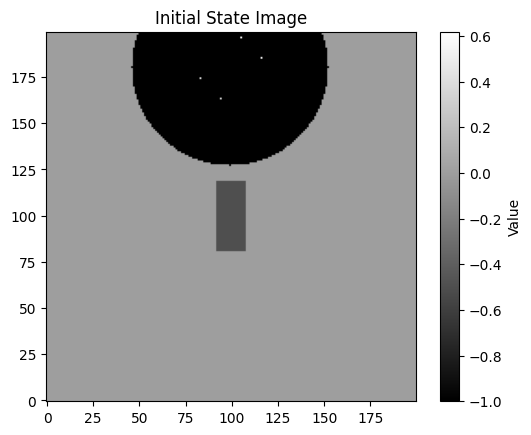

In [7]:
# grab a random state
state = env.get_state()
start_time = timeit.default_timer()
nn_car_state, nn_image_state = mcts_rl.get_nn_state(state)
print(f'Time to get NN state: {timeit.default_timer() - start_time}')

plot_state_image(image, 'Initial State Image')

In [ ]:
tuple_of_tensors = (torch.tensor([1, 2, 3], device=mcts_rl.device), torch.tensor([4, 5, 6], device=mcts_rl.device))
print(f'Tuple of tensors: {tuple_of_tensors}')
print(f'Concatenated tensors: {torch.stack(tuple_of_tensors).shape}')
tensor_stack = torch.stack(tuple_of_tensors)
tensor_stack.gather(1, torch.tensor([[2], [1]], device=mcts_rl.device)).squeeze()

Tuple of tensors: (tensor([1, 2, 3], device='cuda:0'), tensor([4, 5, 6], device='cuda:0'))
Concatenated tensors: torch.Size([2, 3])


tensor([3, 5], device='cuda:0')

In [ ]:
tuple_of_tensors = (torch.tensor([1], device=mcts_rl.device), torch.tensor([4], device=mcts_rl.device))
print(f'Tuple of tensors: {tuple_of_tensors}')
print(f'Concatenated tensors: {torch.cat(tuple_of_tensors).shape}')

Tuple of tensors: (tensor([1], device='cuda:0'), tensor([4], device='cuda:0'))
Concatenated tensors: torch.Size([2])


Convolutional Layer Weights:
Parameter containing:
tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]], requires_grad=True)

Input Image:
tensor([[[[0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0.]]]])

Output Feature Map after Convolution:
tensor([[[[-1.,  0.,  0.,  0.,  1.],
          [-2.,  0.,  0.,  0.,  2.],
          [-3.,  0.,  0.,  0.,  3.],
          [-2.,  0.,  0.,  0.,  2.],
          [-1.,  0.,  0.,  0.,  1.]]]], grad_fn=<ConvolutionBackward0>)


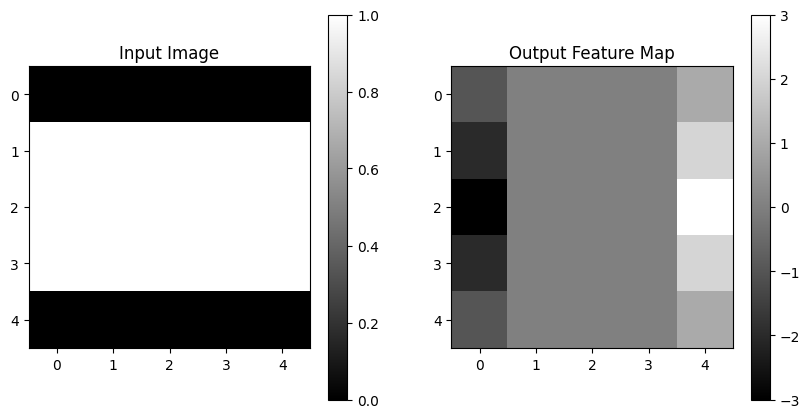

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define a simple 2D convolutional layer
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)

# Initialize the weights with specific values for better understanding (optional)
conv_layer.weight = nn.Parameter(torch.tensor([[[[1, 0, -1],
                                                 [1, 0, -1],
                                                 [1, 0, -1]]]], dtype=torch.float32))
conv_layer.bias = nn.Parameter(torch.tensor([0.0]))

# Print out the weights
print("Convolutional Layer Weights:")
print(conv_layer.weight)

# Create a simple 5x5 input image (e.g., a vertical edge)
input_image = torch.tensor([[[[0, 0, 0, 0, 0],
                              [1, 1, 1, 1, 1],
                              [1, 1, 1, 1, 1],
                              [1, 1, 1, 1, 1],
                              [0, 0, 0, 0, 0]]]], dtype=torch.float32)

# Pass the image through the convolutional layer
output = conv_layer(input_image)

# Print out the input and output
print("\nInput Image:")
print(input_image)

print("\nOutput Feature Map after Convolution:")
print(output)

# Visualize the input and output
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_image.squeeze(), cmap='gray')
plt.title("Input Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(output.detach().numpy().squeeze(), cmap='gray')
plt.title("Output Feature Map")
plt.colorbar()

plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader

# Assume `dataset` is your experience replay buffer or training data

def find_optimal_batch_size(model, dataset, init_batch_size=32, max_memory_utilization=0.9):
    batch_size = init_batch_size
    while True:
        try:
            # Create a DataLoader with the current batch size
            data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            # Run a forward pass to check memory usage
            for batch in data_loader:
                inputs = batch['input'].to('cuda')
                outputs = model(inputs)
                loss = some_loss_function(outputs, batch['target'])
                loss.backward()
                # Check GPU memory usage
                memory_allocated = torch.cuda.memory_allocated()
                total_memory = torch.cuda.get_device_properties(0).total_memory
                utilization = memory_allocated / total_memory
                if utilization > max_memory_utilization:
                    print(f"Memory utilization {utilization:.2f}, reducing batch size")
                    batch_size //= 2
                    return batch_size
            # If memory usage is fine, increase batch size
            print(f"Batch size {batch_size} fits in memory, doubling batch size")
            batch_size *= 2
        except RuntimeError as e:
            if 'out of memory' in str(e):
                print("OOM Error, reducing batch size")
                batch_size //= 2
                return batch_size
            else:
                raise e

# Example usage
optimal_batch_size = find_optimal_batch_size(your_model, your_dataset)
print(f"Optimal batch size: {optimal_batch_size}")


NameError: name 'your_model' is not defined